<a href="https://colab.research.google.com/github/sbooeshaghi/adcellcell/blob/main/adcellcell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
!pip install --quiet leidenalg louvain anndata umap-learn pynndescent session-info
!pip install --quiet --no-deps scanpy

     |████████████████████████████████| 1.3 MB 9.7 MB/s 
     |████████████████████████████████| 1.1 MB 47.1 MB/s 
     |████████████████████████████████| 96 kB 3.6 MB/s 
     |████████████████████████████████| 88 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 44.5 MB/s 
     |████████████████████████████████| 3.2 MB 37.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 2.0 MB 7.6 MB/s 


In [963]:
!git clone --quiet https://github.com/sbooeshaghi/adcellcell

In [920]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, scale

import numpy.lib.recfunctions as rf

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [921]:
# centroids  = pd.read_csv("calculated_cell_locations.csv", index_col=0)
# centroids["cellnum"] = pd.Series(centroids.index).apply(lambda x: x.split("cell")[-1].split("_")[0]).astype(float).astype(int).values
# centroids["pos"] = pd.Series(centroids.index).apply(lambda x: x.split("cell")[-1].split("pos")[-1]).astype(int).values
# centroids.index = "Cell" + centroids["cellnum"].astype(str) + "_Pos" + centroids["pos"].astype(str)
# centroids["X_final"] = centroids["X_final"] + np.abs(centroids["X_final"].min())
# centroids["Y_final"] = centroids["Y_final"] + np.abs(centroids["Y_final"].min())


In [922]:
# adata = anndata.read_h5ad("adata.h5ad")

In [923]:
# adata.obs["cellnum"] = pd.Series(adata.obs.index).apply(lambda x: x.split("Cell")[-1].split("_")[0]).astype(float).astype(int).values
# adata.obs["pos"] = pd.Series(adata.obs.index).apply(lambda x: x.split("Cell")[-1].split("_")[-1]).astype(int).values
# adata.obs["cell"] = "Cell" + adata.obs["cellnum"].astype(str) + "_Pos" + adata.obs["pos"].astype(str)
# df = pd.DataFrame(adata.X.A, index=adata.obs["cell"]).groupby("cell").sum()
# ndata = anndata.AnnData(X = csr_matrix(df.values), obs = pd.DataFrame(index=df.index), var = adata.var)
# ndata.obs["x"] = ndata.obs.index.map(centroids["X_final"])
# ndata.obs["y"] = ndata.obs.index.map(centroids["Y_final"])

In [924]:
# adata = ndata.copy()
# adata.layers["raw"] = adata.X.copy()

In [925]:
# save = adata.copy()

In [926]:
# adata.write_h5ad("raw.h5ad")

In [937]:
adata = anndata.read_h5ad("adcellcell/raw.h5ad")

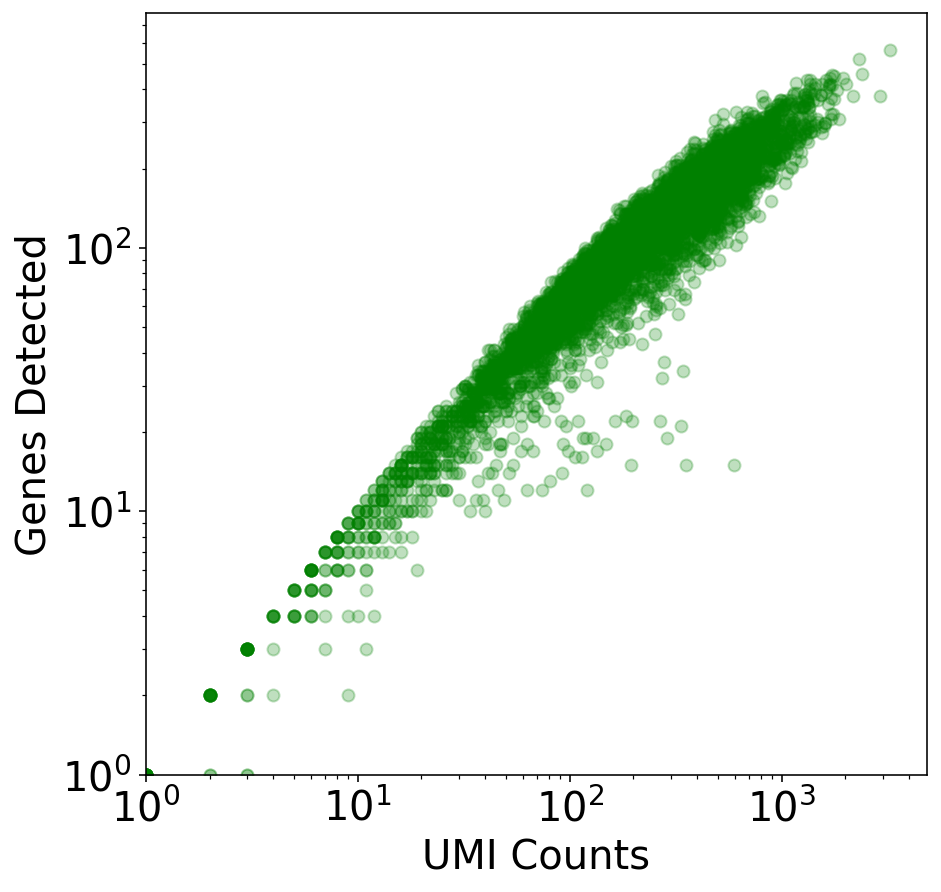

In [938]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(7, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)


plt.show()

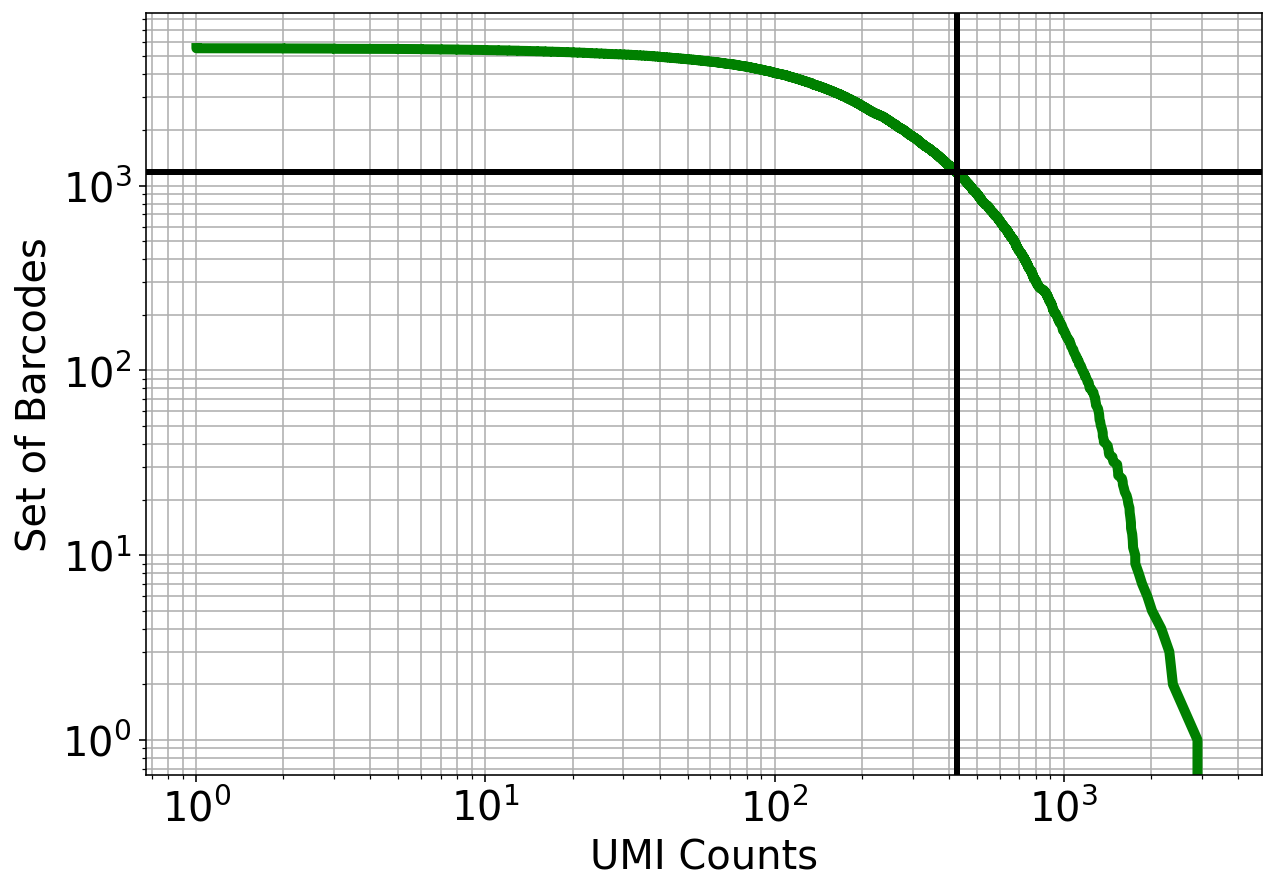

In [939]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  1178#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

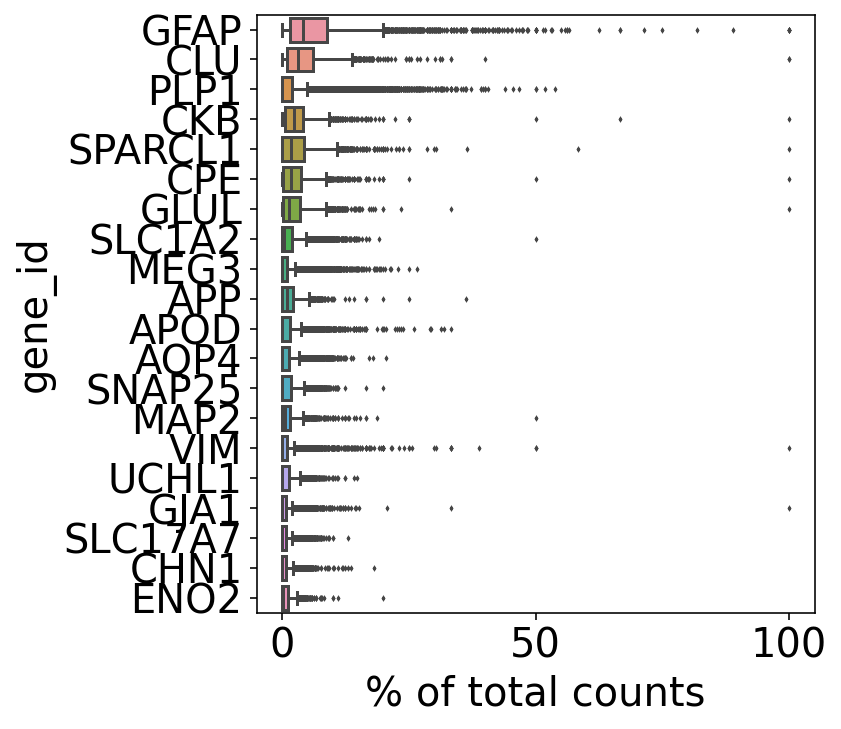

In [940]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [941]:
mgenes = {"eN.1": ["SLC17A7","SNAP25","SYT1","UCHL1","VSNL1", "ENO2"],
"O.1": ["PLP1","TF","QDPR","CNDP1","PLEKHH1"],
"O.2": ["PLP1","TF","OLIG1","RORB","APOD"],
"A": ["AQP4","GJA1","SLC1A2","FGFR3","APOE"],
"eN.A": ["GFAP","FAM107A","NEFL","MAP2","VSNL1"],
"E.1": ["VIM","ITM2A", "TAGLN2","GNAI2","FOXC1"],
"iN.LHX6": ["GAD1","LHX6","PVALB","SNCG","SST", "SPARCL1"],
"E.2": ["FLNA","SPARC","VIM","EPS8","CDH6"],
"M": ["CD74","C3","SRGAP2","CX3CR1","ITGB2"],
"eN.L2": ["LAMP5","CHN1,ENC1","VSNL1","PHYHIP"],
"eN.L5": ["FEZF2","DIRAS2","MEG3","SLC17A7","CHN1"],
"OPC": ["OLIG1","PDGFRA","RORB","APOD","SMOC1"],
"iN.ADARB2.CALB2": ["GAD1","CALB2","ADARB2","CNR1","VIP"],
"iNeuron.ADARB2.LAMP5": ["LAMP5","GAD1","ADARB2","KIT","SYT1", "NDNF", "GLUL"],
"E.3": ["SPARC","MLC1","ZFP36L1","AEBP1","GJA1"]}

In [942]:
g = np.unique(np.array([item for sublist in mgenes.values() for item in sublist]))

In [943]:
g

array(['ADARB2', 'AEBP1', 'APOD', 'APOE', 'AQP4', 'C3', 'CALB2', 'CD74',
       'CDH6', 'CHN1', 'CHN1,ENC1', 'CNDP1', 'CNR1', 'CX3CR1', 'DIRAS2',
       'ENO2', 'EPS8', 'FAM107A', 'FEZF2', 'FGFR3', 'FLNA', 'FOXC1',
       'GAD1', 'GFAP', 'GJA1', 'GLUL', 'GNAI2', 'ITGB2', 'ITM2A', 'KIT',
       'LAMP5', 'LHX6', 'MAP2', 'MEG3', 'MLC1', 'NDNF', 'NEFL', 'OLIG1',
       'PDGFRA', 'PHYHIP', 'PLEKHH1', 'PLP1', 'PVALB', 'QDPR', 'RORB',
       'SLC17A7', 'SLC1A2', 'SMOC1', 'SNAP25', 'SNCG', 'SPARC', 'SPARCL1',
       'SRGAP2', 'SST', 'SYT1', 'TAGLN2', 'TF', 'UCHL1', 'VIM', 'VIP',
       'VSNL1', 'ZFP36L1'], dtype='<U9')

In [944]:
# Normalize depth
adata.layers["PF"] = normalize(adata.layers["raw"], norm="l1")*adata.layers["raw"].sum(1).mean()
# log1pPF
adata.layers["log1pPF"] = np.log1p(adata.layers["PF"])
adata.layers["centerlog1pPF"] = scale(adata.layers["log1pPF"].A, with_std=False)

# PFlog1pPF
adata.layers["PFlog1pPF"] = normalize(adata.layers["log1pPF"], norm="l1")*adata.layers["log1pPF"].sum(1).mean()

# scale
adata.layers["scalelog1pPF"] = scale(adata.layers["log1pPF"].A)

adata.X = adata.layers["log1pPF"].copy()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


In [945]:
fadata = adata[:,adata.var.index.isin(g)]

In [946]:
sc.pp.highly_variable_genes(adata, layer="log1pPF")

In [947]:
adata.X = adata.layers["PFlog1pPF"].copy()

In [948]:
# We perform PCA on just the highly variable genes
sc.tl.pca(adata, svd_solver='arpack', n_comps=100, use_highly_variable=False)

sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_pca")

sc.tl.leiden(adata, random_state=42)

print(adata.obs["leiden"].nunique())
print(adata.obs["leiden"].value_counts())


10
0    1020
1     976
2     691
3     592
4     494
5     484
6     480
7     304
8     281
9     234
Name: leiden, dtype: int64


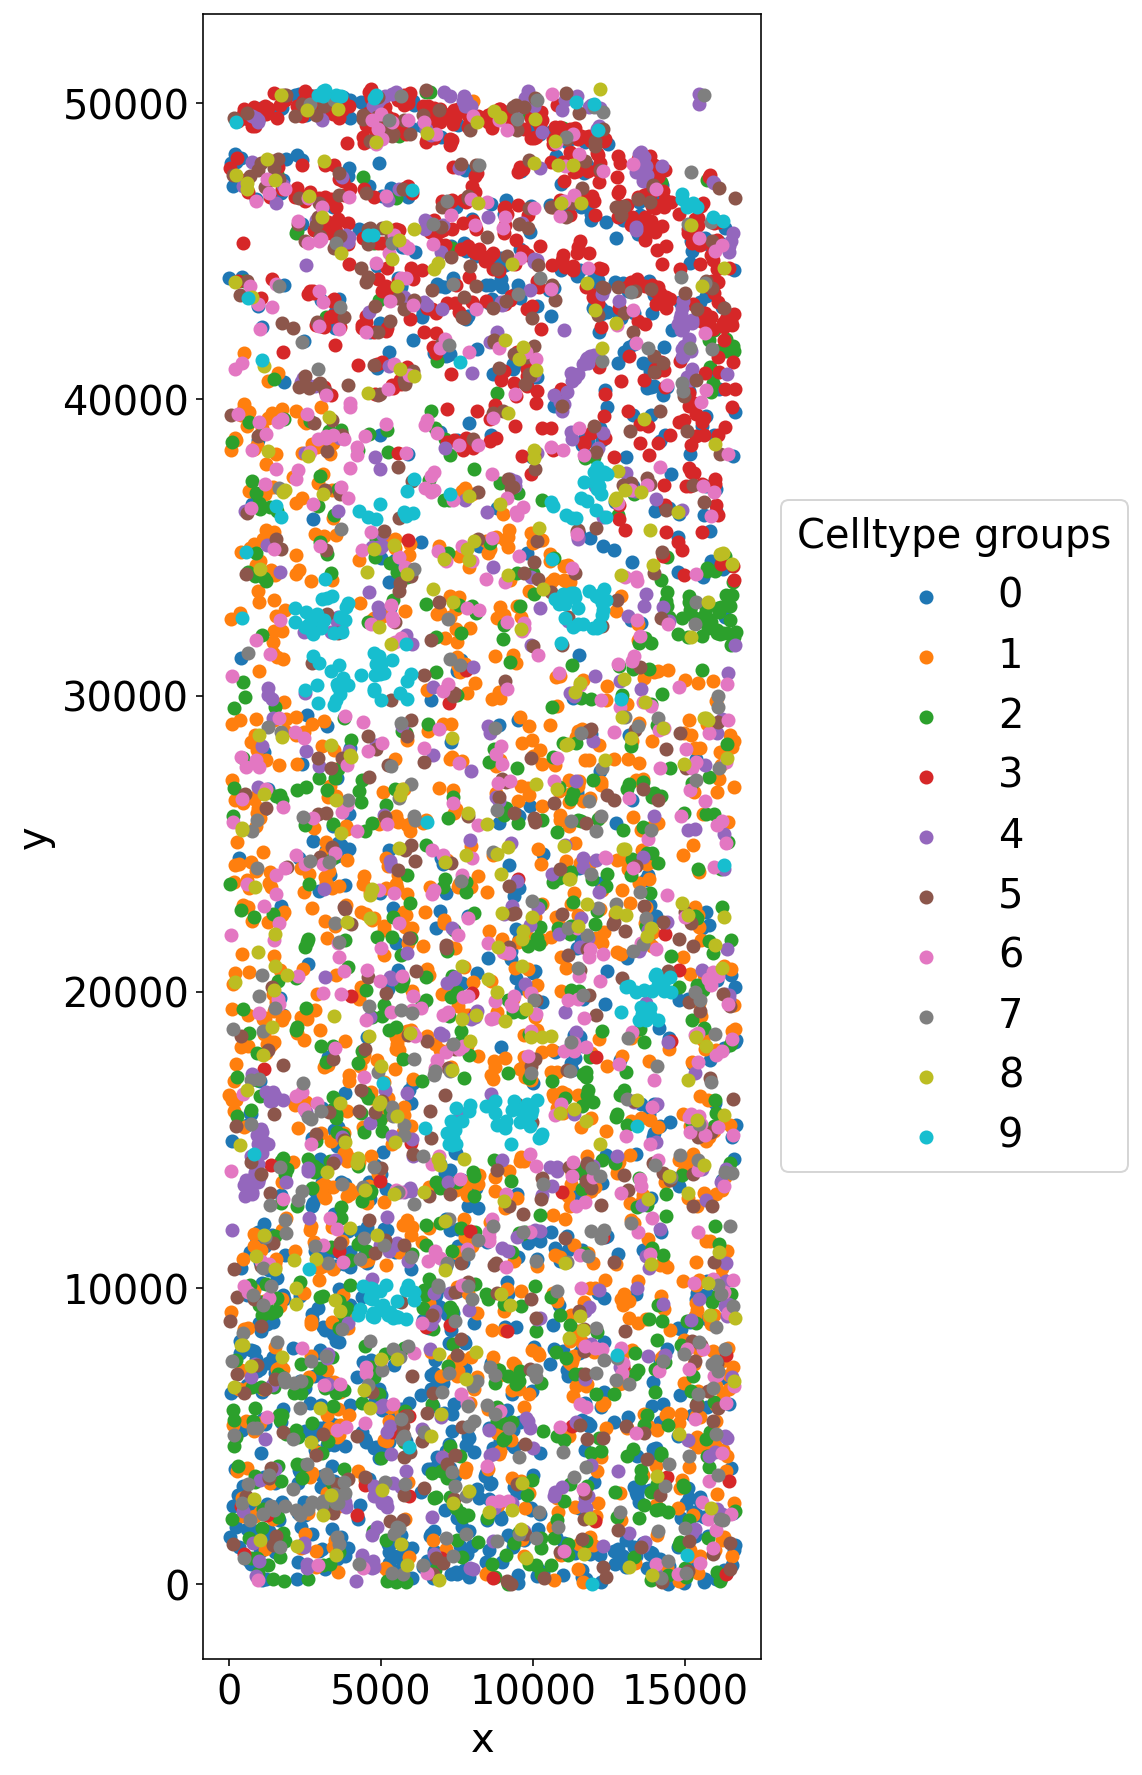

In [949]:
s = 5
x,y = adata.obs.x,adata.obs.y

fig, ax = plt.subplots(figsize=(s, y.max()/x.max()*s))

assignments = adata.obs.leiden.values.astype(int)
for l in np.unique(assignments):
  mask = assignments == l
  xx = x[mask]
  yy = y[mask]
  ax.scatter(xx,yy, label=l, cmap="tab20b")

ax.set(**{
    "xlabel": "x",
    "ylabel": "y",
})

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Celltype groups")

fig.show()

In [950]:
pd.Series(adata[adata.obs.eval("leiden == '9'")].X.A.mean(0), index = adata.var.index).sort_values()

gene_id
KBTBD8      0.000000
HLA-DQA1    0.000000
FGF9        0.000000
DGCR6L      0.000000
FRMPD4      0.000000
              ...   
FAM107A     0.921475
STON2       0.973853
ENO2        1.221336
APP         1.487693
GJA1        1.567376
Length: 1440, dtype: float32

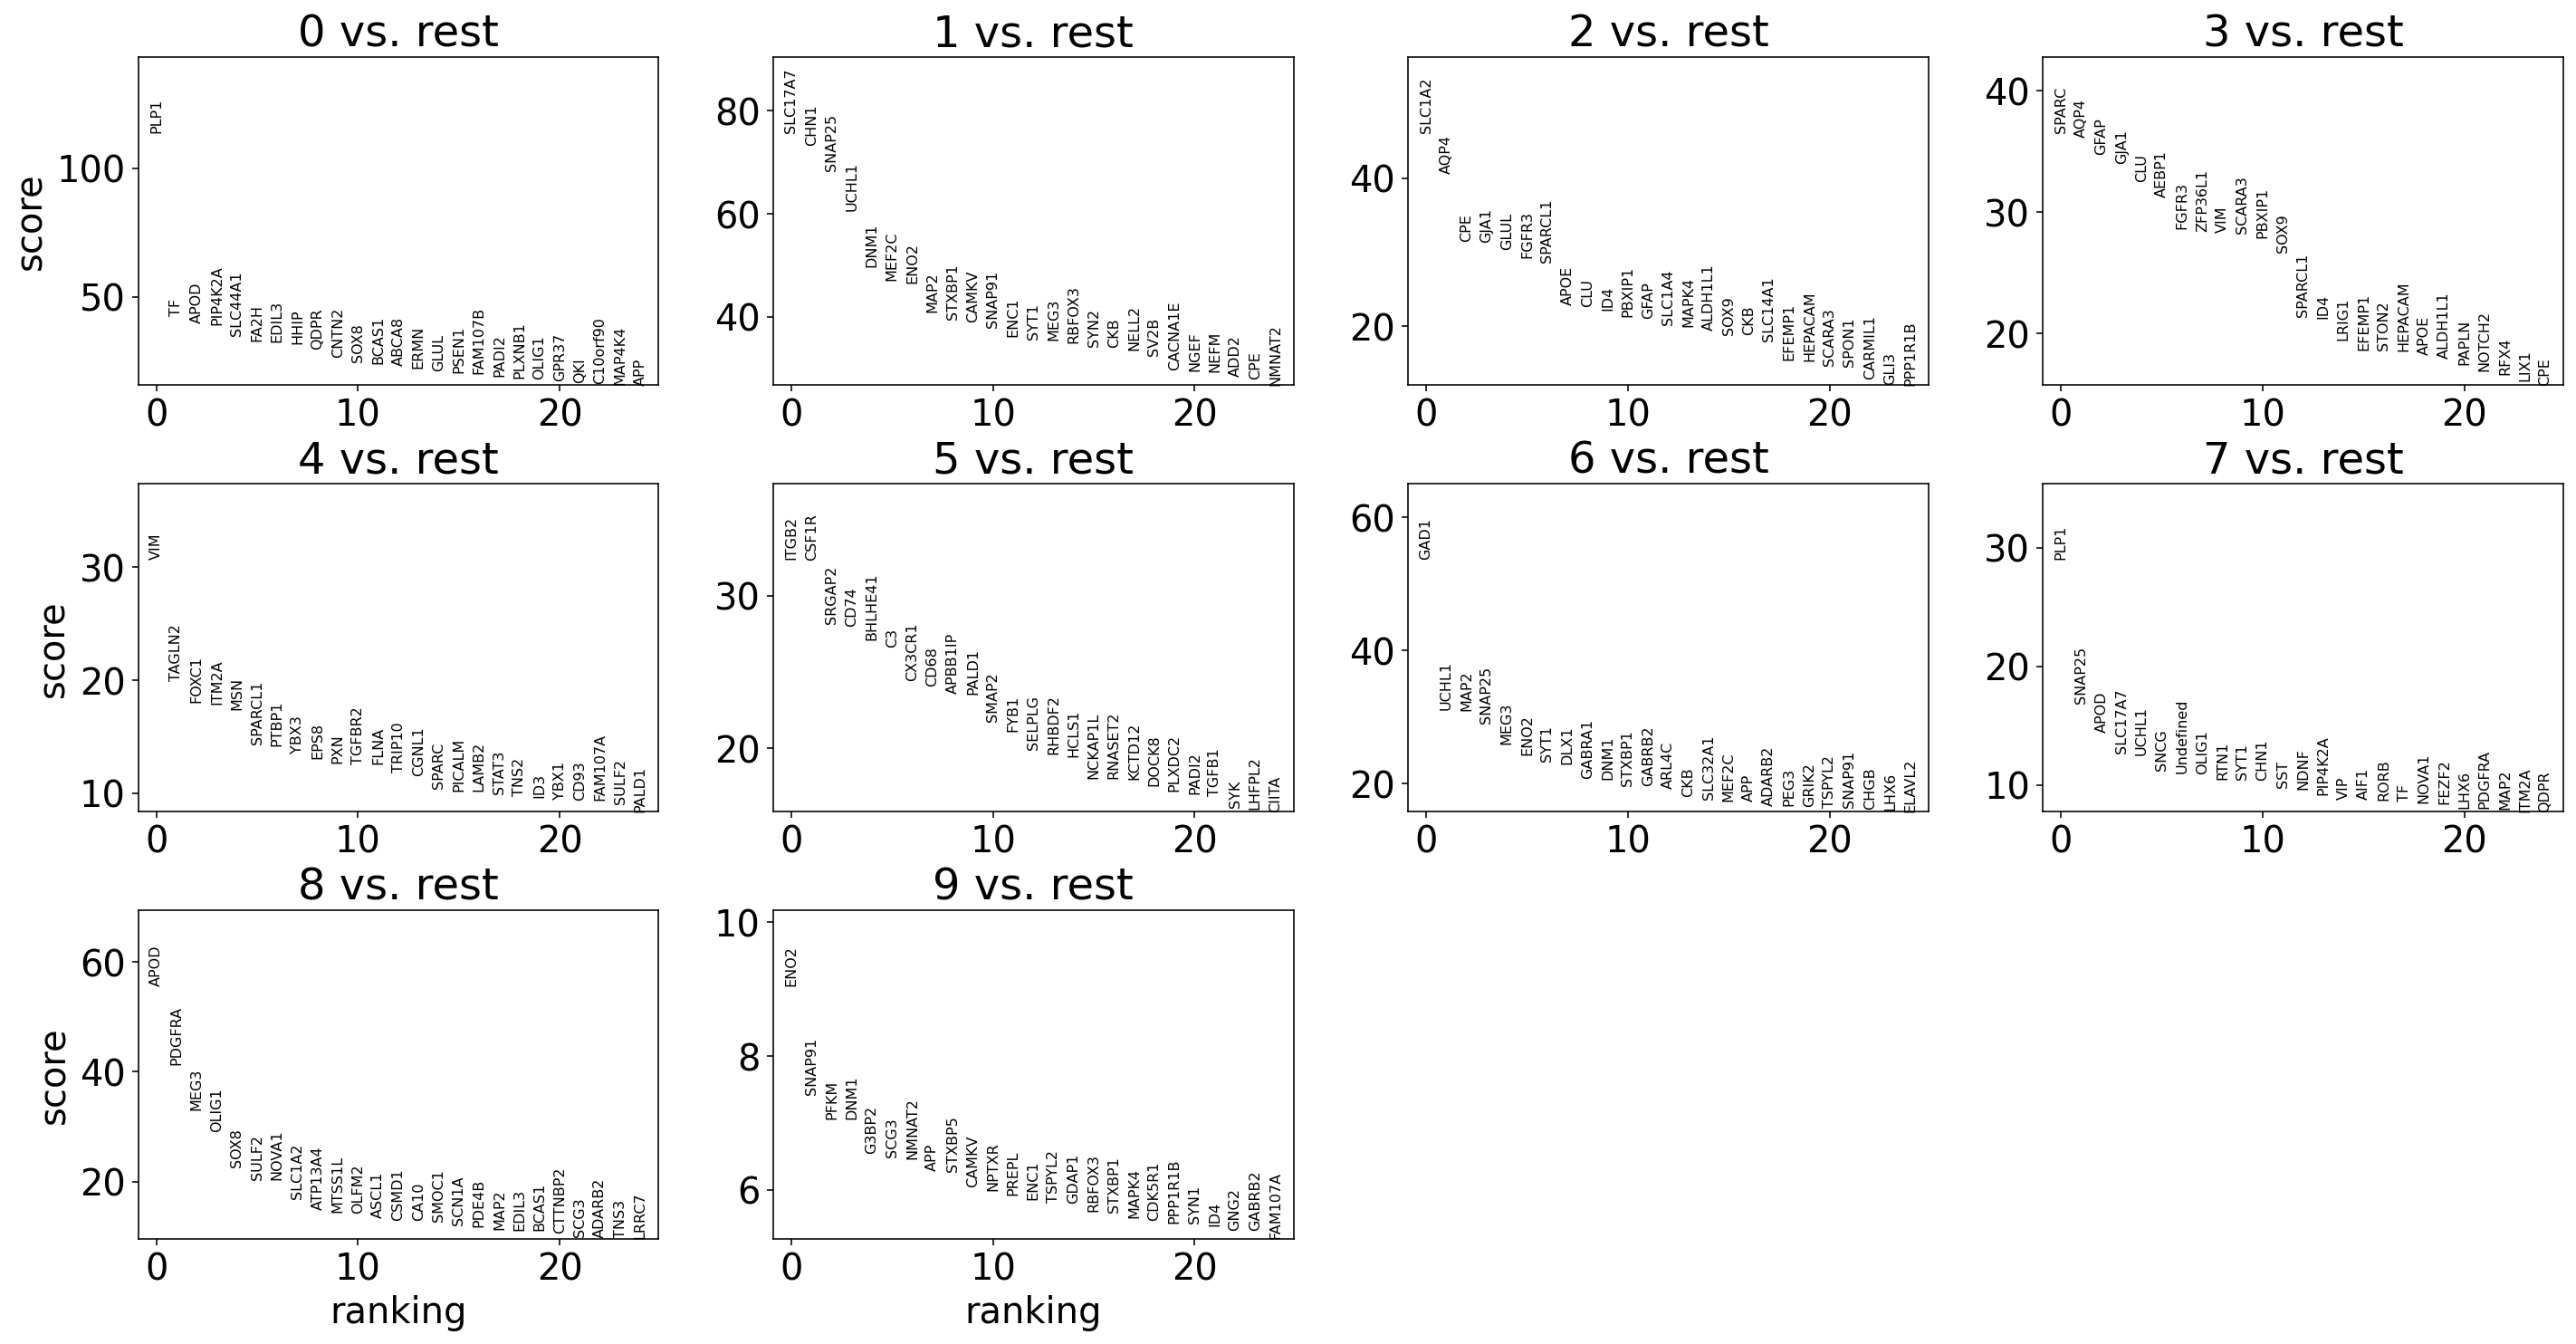

In [951]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', corr_method="bonferroni", layer="log1pPF")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [952]:
pvals = rf.structured_to_unstructured(adata.uns["rank_genes_groups"]["pvals_adj"]).ravel()
scores = rf.structured_to_unstructured(adata.uns["rank_genes_groups"]["scores"]).ravel()
names = np.array([np.asarray(tuple(i)) for i in adata.uns["rank_genes_groups"]["names"]]).ravel()
leiden = np.tile(np.arange(0, adata.obs.leiden.nunique()), adata.shape[1]).reshape(-1, adata.obs.leiden.nunique()).ravel()

In [953]:
df = pd.DataFrame({"pvals": pvals, "scores": scores, "names": names, "leiden": leiden})

In [954]:
df

,pvals,scores,names,leiden
0,0.000000e+00,113.728271,PLP1,0
1,0.000000e+00,75.725166,SLC17A7,1
2,1.083856e-230,46.127838,SLC1A2,2
3,1.675236e-159,36.541489,SPARC,3
4,5.700344e-117,30.703753,VIM,4
...,...,...,...,...
14395,1.013532e-210,-34.079910,MEG3,5
14396,1.511437e-121,-24.858795,TF,6
14397,2.661707e-62,-19.628525,ZFP36L1,7
14398,6.647261e-115,-23.698116,PAPLN,8


In [955]:
from collections import defaultdict
rev = defaultdict(list)
for k,v in mgenes.items():
  for i in v:
    rev[i].append(k)

In [956]:
df["ct"] = df["names"].map(rev)

In [957]:
from collections import Counter

In [958]:
asn = {}
for idx, r in zip(df.query("pvals < = 0.0001 & scores > 5").groupby("leiden")["ct"].apply(list).index, df.query("pvals < = 0.0001 & scores > 5").groupby("leiden")["ct"].apply(list)):
  tmp = Counter([item for sublist in r for item in sublist])
  asn[idx] = tmp.most_common(1)[0][0]

In [959]:
asn

{0: 'O.1',
 1: 'eN.1',
 2: 'A',
 3: 'E.3',
 4: 'E.2',
 5: 'M',
 6: 'iNeuron.ADARB2.LAMP5',
 7: 'O.2',
 8: 'OPC',
 9: 'eN.1'}

In [960]:
adata.obs["celltype"] = adata.obs["leiden"].astype(int).map(asn)

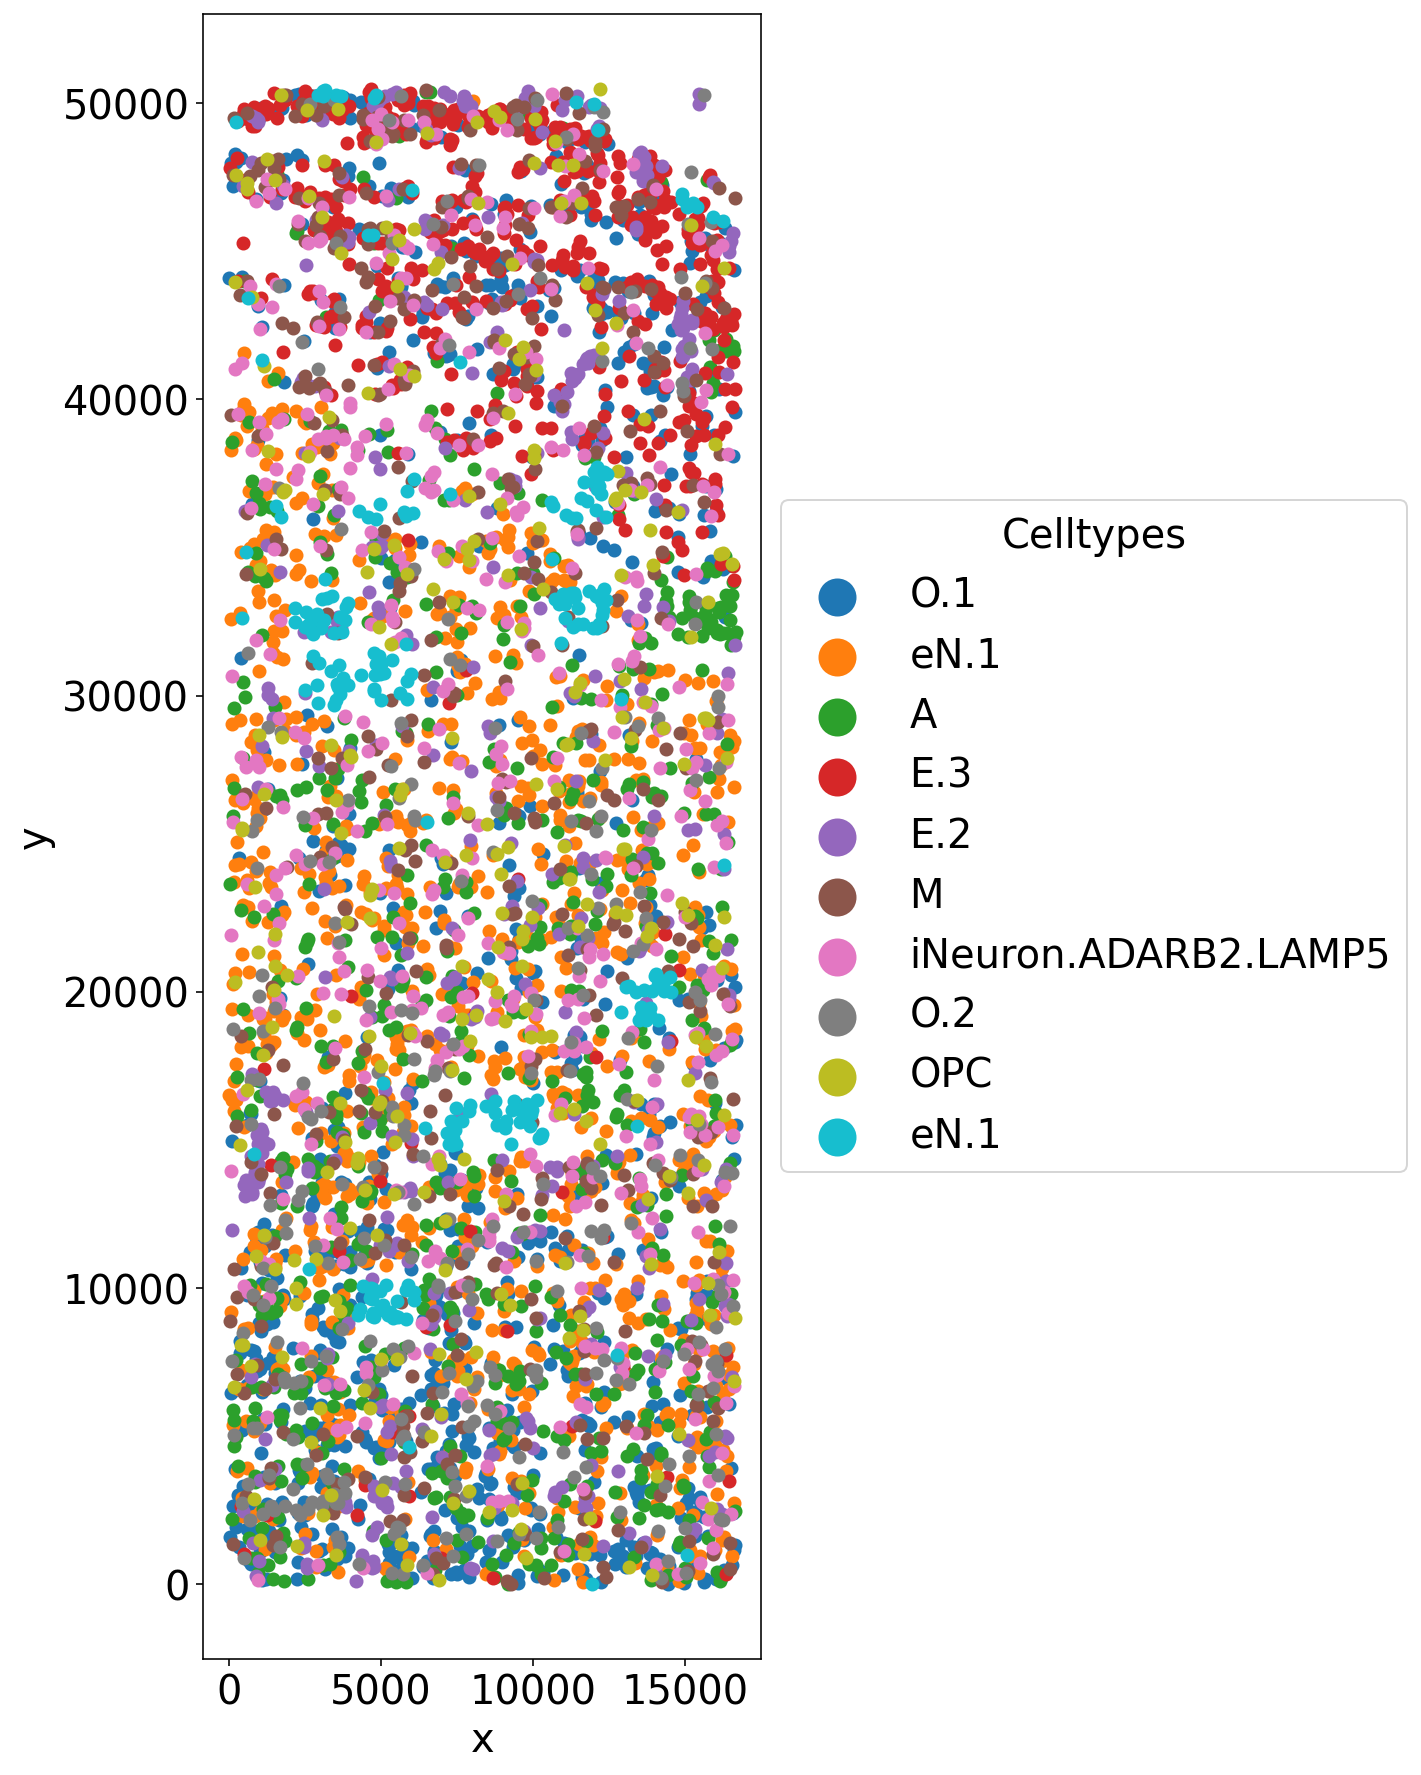

In [962]:
s = 5
x,y = adata.obs.x,adata.obs.y

fig, ax = plt.subplots(figsize=(s, y.max()/x.max()*s))

assignments = adata.obs.leiden.values.astype(int)
for l in np.unique(assignments):
  mask = assignments == l
  xx = x[mask]
  yy = y[mask]
  ax.scatter(xx,yy, label=asn[l], cmap="tab20b")

ax.set(**{
    "xlabel": "x",
    "ylabel": "y",
})

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Celltypes", markerscale=3)
fig.savefig("87779516_slice7-clustermap.png", dpi=300, bbox_inches="tight")
fig.show()

In [912]:
adata.write_h5ad("processed.h5ad")